In [7]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
from skimage.morphology import erosion, dilation, opening, closing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
from IPython.display import Image as IPImage, display


In [8]:
#Visualize function
def visualize(image, gray = False, hsv_rep = False):
    plt.figure(figsize=(10, 5))

    if hsv_rep and not gray:
        img = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        plt.imshow(img) 

    elif not hsv_rep and gray:
        plt.imshow(image, cmap='gray')

    else:
        plt.imshow(image) 

    plt.show()

In [9]:
image_path = 'alfie_lm_ball_line0001.png' 

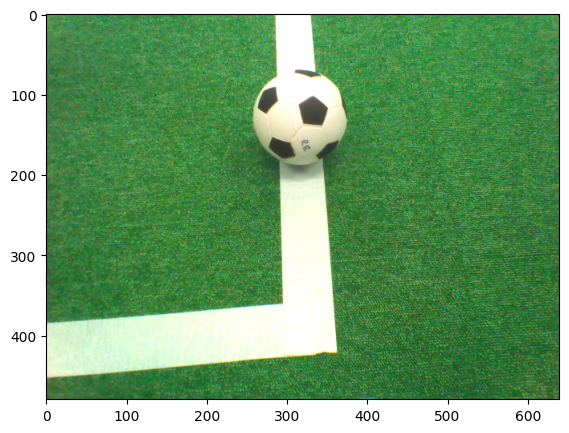

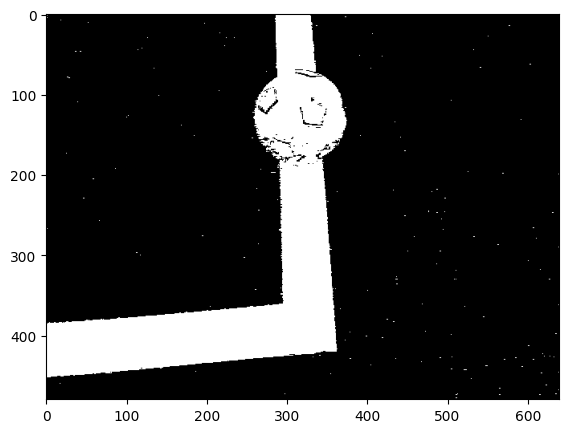

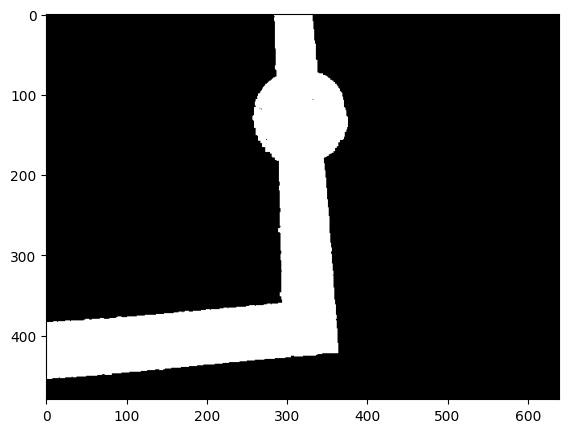

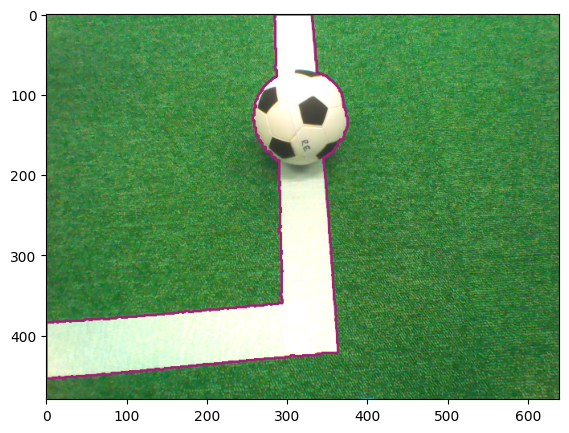

In [10]:
frame = cv2.imread(image_path)
frame_copy =frame.copy()
frame_copy2 =frame.copy()
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

#Normal
visualize(frame)

#Binary
threshold_value = 70 #param

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
_, mask_inv = cv2.threshold(hsv[:, :, 1], threshold_value, 255, cv2.THRESH_BINARY)
mask =cv2.bitwise_not(mask_inv)
visualize(mask, gray=True)

#Erosion and dilation
iterat_erode = 1 #param
k_erode = 2 #param
iterat_dilate = 1 #param
k_dilate = 5 #param


kernel_erode = np.ones((k_erode, k_erode), np.uint8)
kernel_dilate = np.ones((k_dilate, k_dilate), np.uint8)
mask1 = cv2.erode(mask, kernel_erode, iterat_erode) 
mask2 = cv2.dilate(mask1, kernel_dilate, iterat_dilate) 
visualize(mask2, gray = True)

#Contours in purple
mask = mask2
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None
for c in cnts:
    cv2.drawContours(frame, [c], -1, (160, 34, 119), 2)
visualize(frame)

In [11]:
def calculate_curvature(contour):
    # Check if the contour has enough points to calculate curvature
    if len(contour) < 3:
        return np.zeros(len(contour))


    if len(contour.shape) == 3:
        contour = np.squeeze(contour, axis=1)

    # Extract x and y coordinates
    x = contour[:, 0]
    y = contour[:, 1] 

    # Calculate curvature
    dx = np.gradient(x)
    dy = np.gradient(y)

    # Calculate second derivatives
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    # Calculate curvature
    curvature = np.abs(dx * d2y - dy * d2x) / (dx**2 + dy**2)**(3/2)

    return curvature

def segment_contour(contour, curvature_threshold):
    curvature = calculate_curvature(contour)

    # Find indices where curvature exceeds the threshold
    change_indices = np.where(curvature > curvature_threshold)[0]
    #print(curvature[np.where(curvature > curvature_threshold)])

    # Add the start and end indices of the contour
    change_indices = np.concatenate([[0], change_indices, [len(contour)-1]])

    # Create segments based on change indices
    segments = [contour[change_indices[i]:change_indices[i+1]+1] for i in range(len(change_indices)-1)]

    return segments

def find_center_and_radius(curve_points):
    # Ensure we have enough points
    if len(curve_points) < 3:
        raise ValueError("Insufficient points to find the center and radius.")

    # Divide the curve into three segments
    segment_size = len(curve_points) // 2
    segments = [curve_points[i:i+segment_size] for i in range(0, len(curve_points), segment_size)]

    # Calculate the center and radius for each pair of adjacent segments
    centers = []
    for i in range(1):
        center = find_center(segments[i], segments[i+1])
        centers.append(center)

    # Take the mean value of the centers
    final_center = np.mean(np.array(centers), axis=0)

    # Calculate the radius using one of the pairs
    radius = np.linalg.norm(np.array(final_center) - np.array(segments[0][0])) #first point of the first segment

    return final_center, radius

def find_center(segment1, segment2):
    # Find the two most distant points in each segment
    point1, point2 = segment1[0], segment1[-1]
    point3, point4 = segment2[0], segment2[-1]

    # Cast normal axes from the midpoint of the first line segment
    mid_point1 = ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)
    mid_point2 = ((point3[0] + point4[0]) / 2, (point3[1] + point4[1]) / 2)
    axis1_dir = (point2[1] - point1[1], -(point2[0] - point1[0]))  #Normal vector is (y, -x)
    axis2_dir = (point4[1] - point3[1], -(point4[0] - point3[0])) 
    
    # Find the intersection point of the two lines
    intersection = find_intersection(mid_point1, axis1_dir, mid_point2, axis2_dir)

    return intersection

def find_intersection(p1, d1, p2, d2):
    # Find the intersection of two lines given their points and directions
    A = np.array([[d1[0], -d2[0]], [d1[1], -d2[1]]])
    if np.linalg.det(A) == 0:
        return [10000000, 10000000]
    b = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    t1, t2 = np.linalg.solve(A, b)
    intersection = [p1[0] + t1 * d1[0], p1[1] + t1 * d1[1]]
    return intersection

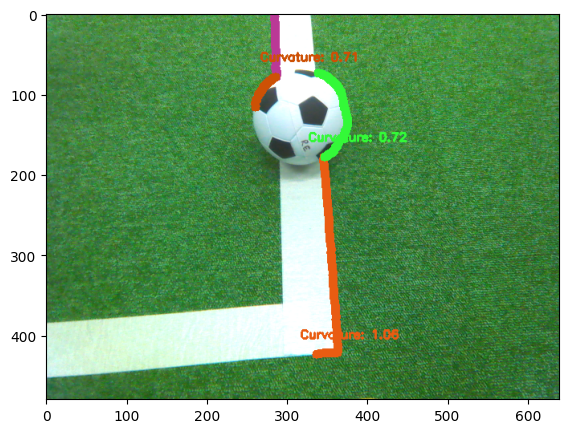

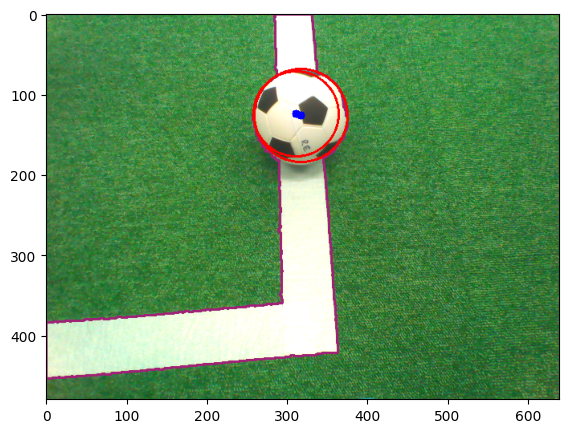

In [16]:
curvature_threshold = 1 #param  
curv_min = 0.1 #param
curv_max = 1.76 #param
radius_max = 300 #param
threshold_black_value = 150 #param

circles = []
for contour in cnts:    
    segments = segment_contour(contour, curvature_threshold)
    for segment in segments:
        color = np.random.randint(0, 255, size=3)  # Generate a random color
        color = tuple(map(int, color))

        segment = np.squeeze(segment, axis=(1,))
        curv = np.max(calculate_curvature(segment))
        
        if curv_max > curv > curv_min: 
            text_position = (segment[0][0] - 20, segment[0][1] - 20)
            cv2.putText(frame_copy, f"Curvature: {curv:.2f}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.polylines(frame_copy, [segment], isClosed=False, thickness= 10, color = color)
        
            center, radius = find_center_and_radius(segment)

            circle_roi = frame[int(center[1] - radius):int(center[1] + radius), int(center[0] - radius):int(center[0] + radius)]
            black_pixels = np.sum(circle_roi < threshold_black_value)

            if radius < radius_max and black_pixels > 0:
                cv2.circle(frame, (int(center[0]), int(center[1])), int(radius), 255, 2)
                cv2.circle(frame, (int(center[0]), int(center[1])), 5, (0, 0, 255), -1)

            #((x, y), radius) = cv2.minEnclosingCircle(segment)
            #cv2.circle(frame, (int(x), int(y)), int(radius), 255, 2)


visualize(frame_copy)
visualize(frame)